<a href="https://colab.research.google.com/github/s20488/COV/blob/main/Anastasiia_Ponkratova_CV_lab1_przetwarzanie_obrazu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 1 przetwarzanie obrazu

Dzisiaj zajmiemy się wykrywaniem defektów na zdjęciach. Zadanie ma 4 warianty. W opisie zadania na classroomie możecie sprawdzić po numerze indeksu, na którym zdjęciu bedziecie pracować.

---
Obrazy apap, witamina D, chloraseptic:
Macie za zadanie wyodrębnić na obrazie miejsca, w których powinny znajdować się tabletki, a następnie określić miejsca, w których brakuje tabletek.

Obraz routera:
Macie za zadanie wyodrębnić lampki na obrazie, a następnie określić, które się nie świecą.

---


Zasady zaliczenia:
1. Korzystamy z biblioteki OpenCV. Nie wolno korzystać z sieci neuronowych.
2. Przy każdej operacji z OpenCV należy dodać komentarz wyjaśniający, po co używamy tej operacji.
3. Kod należy opakować w klasę, która umożliwi użytkownikowi uzyskanie informacji, jak dużo mamy braków i w których miejscach. Czyli klasa musi zwracać:
- [ ] obraz przedstawiający obrysowane miejsca na tabletki / lampki z wyróżnionymi brakami
- [ ] informację tekstową o brakach, np. "Blister zawiera 4/8 tabletek."

Przy ocenianiu będziemy brać pod uwagę to, że obrazy mogą się różnić stopniem trudności.

### Dane
Pobieramy folder z obrazkami - obrazki.zip.

In [ ]:
!pip install --upgrade --no-cache-dir gdown

In [ ]:
!gdown 1rHuPWfHHqC5LzEDlKUTwmhD2tUnrJyhh

Downloading...
From (original): https://drive.google.com/uc?id=1rHuPWfHHqC5LzEDlKUTwmhD2tUnrJyhh
From (redirected): https://drive.google.com/uc?id=1rHuPWfHHqC5LzEDlKUTwmhD2tUnrJyhh&confirm=t&uuid=9fdb4bff-04c3-4dfa-b049-dc003ec556f3
To: /content/obrazki.zip
100% 102M/102M [00:00<00:00, 152MB/s] 


In [ ]:
import os
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import zipfile

In [203]:
# TODO: Dokończyć pisać klasę
class DefectDetector():
    def __init__(self, zip_path, image_name):
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extract(image_name, "temp_images")

        self.image_path = os.path.join("temp_images", image_name)
        # Wczytanie obrazu za pomocą OpenCV
        self.image = cv2.imread(self.image_path)

    def preprocess_image(self):
        compressed_image = self.compress_image(self.image)

        # Rozmycie obrazu, aby zmniejszyć szumy
        blurred = cv2.GaussianBlur(compressed_image, (15, 15), 0)
        # Zwiększenie kontrastu obrazu
        contrasted_image = cv2.addWeighted(blurred, 1.4, np.zeros(blurred.shape, blurred.dtype), 0, 0)

        return contrasted_image

    def compress_image(self, image, scale_percent=20):
        width = int(image.shape[1] * scale_percent / 100)
        height = int(image.shape[0] * scale_percent / 100)
        dim = (width, height)

        # Zmniejszenie rozmiaru obrazu
        compressed_image = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)

        return compressed_image

    def detect_tablets_and_defects(self):
        preprocessed_image = self.preprocess_image()

        # Konwersja obrazu do przestrzeni kolorów HSV
        hsv_image = cv2.cvtColor(preprocessed_image, cv2.COLOR_BGR2HSV)

        lower_yellow = np.array([40, 100, 100])
        upper_yellow = np.array([255, 255, 255])
        lower_orange = np.array([17, 100, 100])
        upper_orange = np.array([40, 255, 255])

        # Stworzenie maski koloru dla żółtych i pomarańczowych obszarów
        yellow_mask = cv2.inRange(hsv_image, lower_yellow, upper_yellow)
        orange_mask = cv2.inRange(hsv_image, lower_orange, upper_orange)
        tablets_mask = cv2.bitwise_or(yellow_mask, orange_mask)

        # Zastosowanie morfologicznych operacji na masce w celu usunięcia szumów
        kernel = np.ones((25, 25), np.uint8)
        tablets_mask = cv2.morphologyEx(tablets_mask, cv2.MORPH_OPEN, kernel)

        # Wyszukanie konturów tabletek
        contours, _ = cv2.findContours(tablets_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Narysowanie konturów na obrazie
        result_image = preprocessed_image.copy()
        cv2.drawContours(result_image, contours, -1, (0, 255, 0), 2)

        # Obliczenie liczby tabletek i defektów
        tablets_count = len(contours)
        defects_count = 0
        for contour in contours:
            area = cv2.contourArea(contour)
            # Minimalny obszar konturu dla defektu
            if area < 1000:
                defects_count += 1

        defects_info = f"Blister zawiera {tablets_count - defects_count}/{tablets_count} tabletek."

        return result_image, defects_info

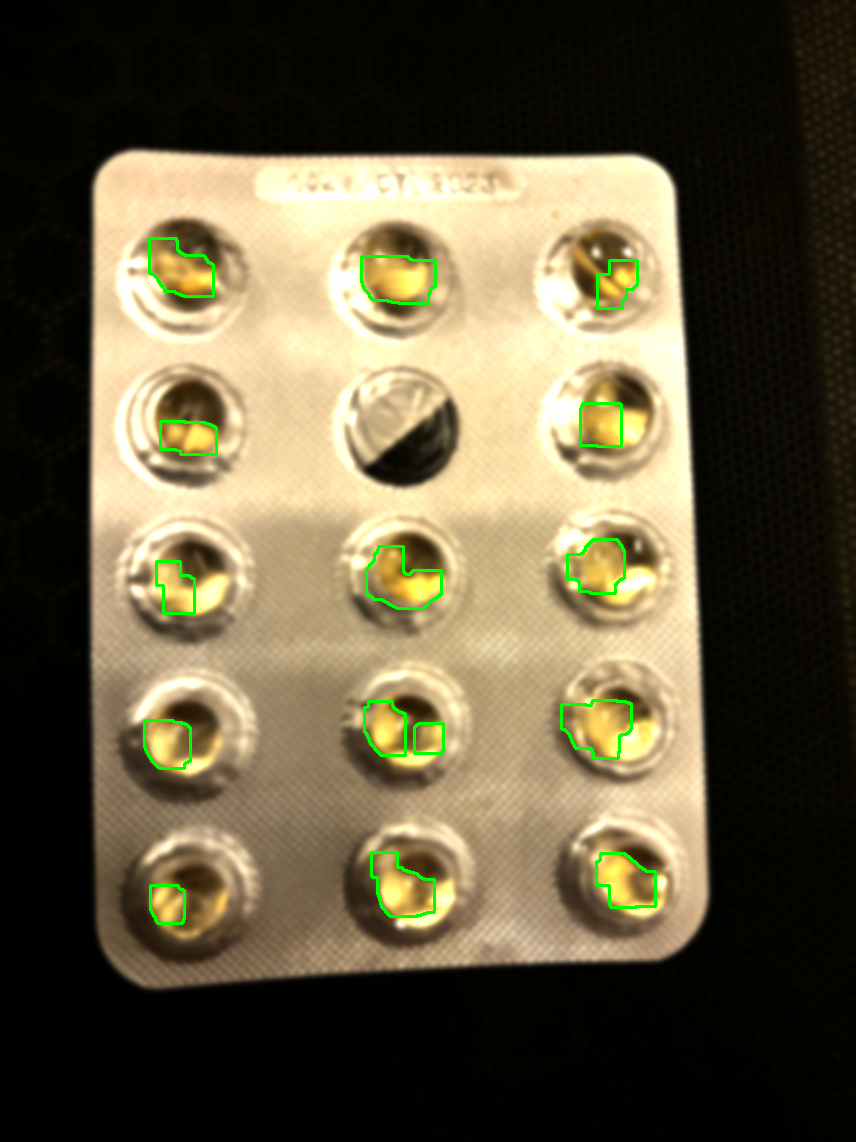

Blister zawiera 14/15 tabletek.


In [204]:
if __name__ == "__main__":
    zip_path = "/content/obrazki.zip"
    image_name = "obrazki/witamina_d.png"

    detector = DefectDetector(zip_path, image_name)
    result_image, defects_info = detector.detect_tablets_and_defects()

    # Wyświetlanie wyników
    cv2_imshow(result_image)
    print(defects_info)
    cv2.waitKey(0)
    cv2.destroyAllWindows()